In this work, various problems related to fluid mechanics were studied. The first one focused on studying the velocity fields of a vortex and a sink.

#Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as animation

##First one: kinematics of simple fluids, numeric solution employing the Runge Kute integrator

In [1]:


def trayectoria(X0, u, N, dt):
  """
  Calcula numéricamente la solución a dX/ds = u(X,t) cómo
  un arreglo, usando el esquema definido previamente

  Parámetros:
    X0: Condición inicial cómo arreglo de dimensión d
    u : Campo de velocidades cómo función de (x,t)
    N : Número de pasos temporales
    dt: Paso temporal
  """
  d = X0.shape[0]            # Dimensión del problema
  ts = np.arange(0, N+1)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((N+1, d))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(N):
    # Aplico esquema anterior sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = esquema(Xs[j], u, ts[j], dt)
  return ts, Xs

def linea_de_corriente(l0, u, t, N, ds):
  """
  Calcula numéricamente la solución a dX/ds = u(X,t) cómo
  un arreglo, usando el esquema definido previamente

  Parámetros:
    l0: Origen de la línea cómo arreglo de dimensión d
    u : Campo de velocidades cómo función de (x,t)
    t : Tiempo para el cual se está calculando la línea
    N : Número de pasos en s
    ds: Paso del parametrizador
  """
  d = l0.shape[0]            # Dimensión del problema
  s = np.arange(0, N+1)*ds   # Valores del parametrizador s
  ls = np.zeros((N+1, d))    # Solución aproximada a lo largo de s
  ls[0] = l0                 # Impongo la condición inicial a s=0
  for j in range(N):
    # Aplico esquema sobre ls[j] para obtener ls[j+1]
    ls[j+1] = esquema(ls[j], u, t, ds)
  return s, ls

def evolucionar_lineas(l0s, ts, u, N, ds, ext=None, figsize=None):
  """
  Calcula numéricamente las líneas de campo y las grafica en
  un video a medida que avanza el tiempo. Asume que existe
  una funcion 'linea_de_corriente' previamente definida.

  Parámetros:
    l0s: Origen de las líneas cómo arreglo de dimensión (n,2)
    u  : Campo de velocidades cómo función de (x,t)
    ts : Tiempos para los cuales se calculan las líneas cómo
         arreglo de dimensión m
    N  : Número de pasos en s
    ds : Paso del parametrizador
    ext: Límites espaciales del grafico [xmin,xmax,ymin,ymax]
figsize: Tamaño de la figura
  """
  n = l0s.shape[0]   # Cantidad de líneas de corriente
  m = ts.shape[0]    # Cantidad de tiempos (fotogramas)
  ls = np.zeros((m, n, N+1, 2))
  for i in range(m):
    for j in range(n):
      _, ls[i,j] = linea_de_corriente(l0s[j], u, ts[i], N, ds)
  xs = ls[:,:,:,0]
  ys = ls[:,:,:,1]

  if ext is None:
    extent = [np.min(np.array(xs)), np.max(np.array(xs)),
              np.min(np.array(ys)), np.max(np.array(ys))]
  else:
    extent = ext

  # Guardo el estado de plt
  params_viejos = plt.rcParams
  plt.rc('animation', html='jshtml')

  fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
  plt.close();  # Cerrar la figura, animation va a crear la suya propia

  # Inicializo las curvas
  plots = [ ax.plot([], [], "b-")[0] for i in range(n) ]
  dots  = [ ax.plot([], [], "ko")[0] for i in range(n) ]
  ax.set_title("$t=0$")
  ax.set_xlabel("x")
  ax.set_ylabel("y")

  def init():
    """ Inicializador de la figura y gráfico de condiciones iniciales."""
    sup = 0
    for i, (x, y) in enumerate(zip(xs[0], ys[0])):
      dots[i].set_xdata([x[0]])
      dots[i].set_ydata([y[0]])
      sup = max(sup, max(np.max(np.abs(x)), np.max(np.abs(y))))

    ax.set_aspect('equal')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])

    return plots

  def actualizar(t):
    """ Actualiza los datos al fotograma actual."""
    print(f"\rCalculando fotograma {t} de {m}",
          end="")

    for i, (x, y) in enumerate(zip(xs[t], ys[t])):
      plots[i].set_xdata(x)
      plots[i].set_ydata(y)

    ax.set_title(f"$t={ts[t]:.5f}$")

    return plots

  anim = animation.FuncAnimation(fig, actualizar, init_func=init,
                                 frames=range(0, m), blit=True, repeat=True)

  # Restauro el estado de plt
  plt.rc(params_viejos)

  return anim


def evolucionar_trazas(X0s, u, N, dt, paso=1, ext=None, figsize=None):
  """
  Calcula numéricamente las líneas de traza y las grafica
  en un video a medida que avanza el tiempo. Asume que
  existe una funcion 'esquema' previamente definida.

  Parámetros:
    X0s: Origen de las trazas cómo arreglo de dimensión (n,2)
    u  : Campo de velocidades cómo función de (x,t)
    N  : Número de pasos temporales
    dt : Paso temporal
   paso: Cantidad de pasos temporales entre fotogramas
    ext: Límites espaciales del grafico [xmin,xmax,ymin,ymax]
figsize: Tamaño de la figura
  """
  n = X0s.shape[0]   # Cantidad de líneas de traza
  ts = np.arange(N+1)*dt
  Xs = np.zeros((N+1, n, N+1, 2))
  for j in range(n):
    Xs[:, j] = X0s[None, j, None]
    for i in range(N):
      for k in range(i//paso+1):
        Xs[i+1, j, k] = esquema(Xs[i, j, k], u, ts[i], dt)
  xs = Xs[:,:,:,0]
  ys = Xs[:,:,:,1]

  if ext is None:
    extent = [np.min(np.array(xs)), np.max(np.array(xs)),
              np.min(np.array(ys)), np.max(np.array(ys))]
  else:
    extent = ext

  # Guardo el estado de plt
  params_viejos = plt.rcParams
  plt.rc('animation', html='jshtml')

  fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
  plt.close();  # Cerrar la figura, animation va a crear la suya propia

  # Inicializo las curvas
  plots = [ ax.plot([], [], "b-")[0] for i in range(n) ]
  dots  = [ ax.plot([], [], "ko")[0] for i in range(n) ]
  ax.set_title("$t=0$")
  ax.set_xlabel("x")
  ax.set_ylabel("y")

  def init():
    """ Inicializador de la figura y gráfico de condiciones iniciales."""
    sup = 0
    for i, (x, y) in enumerate(zip(xs[0], ys[0])):
      dots[i].set_xdata([x[0]])
      dots[i].set_ydata([y[0]])
      sup = max(sup, max(np.max(np.abs(x)), np.max(np.abs(y))))

    ax.set_aspect('equal')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])

    return plots

  def actualizar(t):
    """ Actualiza los datos al fotograma actual."""
    print(f"\rCalculando fotograma {t//paso} de {(N+1)//paso}", end="")

    for i, (x, y) in enumerate(zip(xs[t], ys[t])):
      plots[i].set_xdata(x)
      plots[i].set_ydata(y)

    ax.set_title(f"$t={ts[t]:.5f}$")

    return plots

  anim = animation.FuncAnimation(fig, actualizar, init_func=init,
                                 frames=range(0, N+1, paso),
                                 blit=True, repeat=True)

  # Restauro el estado de plt
  plt.rc(params_viejos)

  return anim

# Plot the animations

Uniform fluid + source Q

<ipython-input-4-3d372741a996>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])
<ipython-input-4-3d372741a996>:20: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])


Text(0.5, 1.0, 'Líneas de corriente | d$s=0.0031622776601683794$')

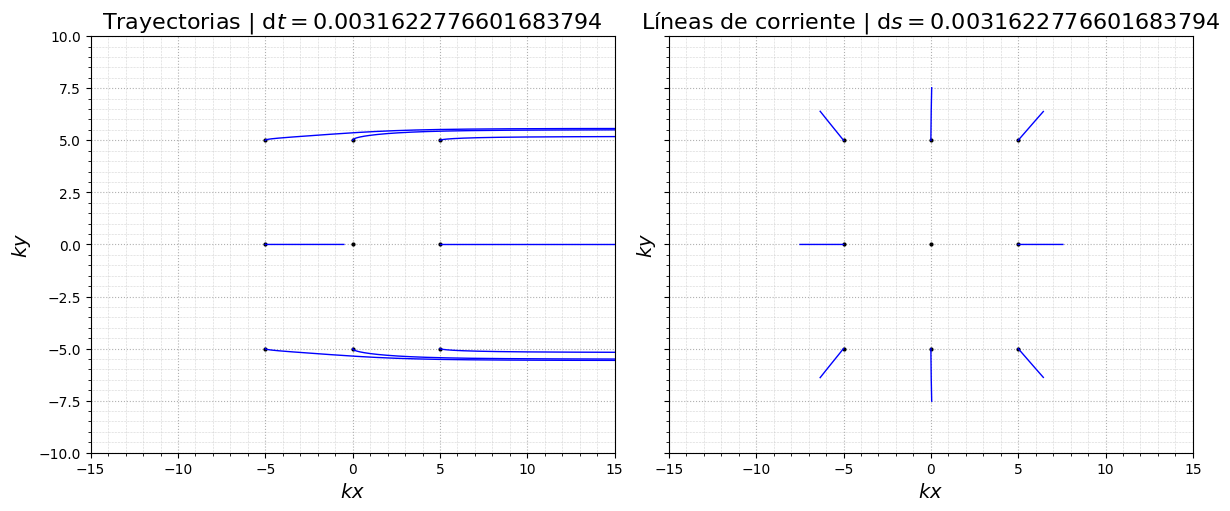

In [ ]:
#Lineal solamente
def esquema(X, u, t, dt):
  """
  Calcula X(t+dt) a partir de X(t) y el campo de velocidades.

  Parámetros:
    X : Solución a tiempo t (X(t)) cómo arreglo de dimensión d
    u : Campo de velocidades cómo función de (x,t)
    t : Tiempo donde se conoce t
    dt: Paso temporal
  """
  return X+(dt/2)*(u(X,t,k)+u(X+dt*u(X,t,k),t+dt,k))



def u(X,t,k):
  R = [[],[]]
  R[0] = np.sqrt(np.abs(X[0]**2+X[1]**2))
  R[1] = np.arctan2(X[1], X[0])
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])

N = 5000
dt = 10**-2.5
#k=2pi c/Q
k=0.25

# Parámetros
lado_matriz = 2  # Número de puntos en cada fila o columna
distancia_entre_puntos = 5.0

# Generar índices de filas y columnas
indices = np.arange(-lado_matriz // 2, lado_matriz // 2 + 1)
columnas, filas = np.meshgrid(indices, indices)

# Coordenadas cartesianas
x = distancia_entre_puntos * columnas
y = distancia_entre_puntos * filas

# Crear la matriz de puntos
p0s = np.column_stack((x.flatten(), y.flatten()))


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True,
                               sharex=True, sharey=True)

for i in range(len(p0s)):
  _, Xs = trayectoria(p0s[i], u, N, dt)
  ax1.plot(Xs[0,0], Xs[0,1], "ko", markersize=2,linewidth=1)
  ax1.plot(Xs[:,0], Xs[:,1], "b-", markersize=2,linewidth=1)


N = 5000
ds = 10**-2.5
for i in range(len(p0s)):
  _, ls = linea_de_corriente(p0s[i], u, 0, N, ds)
  ax2.plot(ls[0,0], ls[0,1], "ko", markersize=2,linewidth=1)
  ax2.plot(ls[:,0], ls[:,1], "b-", markersize=2,linewidth=1)

ax1.set_xlim(-15,15)
ax1.set_ylim(-10,10)

ax1.grid(True, linestyle=':', linewidth=0.8)
ax1.minorticks_on()
ax1.grid(which='minor', linestyle=':', linewidth=0.4)
ax2.grid(True, linestyle=':', linewidth=0.8)
ax2.minorticks_on()
ax2.grid(which='minor', linestyle=':', linewidth=0.4)

ax1.set_xlabel('$kx$', fontsize=14)
ax1.set_ylabel('$ky$', fontsize=14)
ax1.set_title(f'Trayectorias | d$t={dt}$', fontsize=16)
ax2.set_xlabel('$kx$', fontsize=14)
ax2.set_ylabel('$ky$', fontsize=14)
ax2.set_title(f'Líneas de corriente | d$s={ds}$', fontsize=16)


In [ ]:
#Linea de evolucion temporal del campo
ts = np.linspace(0, 5, 5)
evolucionar_lineas(p0s, ts, u, N, ds, ext=[-15,15,-15,15], figsize=None)


<ipython-input-4-3d372741a996>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])
<ipython-input-4-3d372741a996>:20: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])


Calculando fotograma 4 de 5

In [ ]:
#Linea de traza
evolucionar_trazas(p0s, u, N, dt, paso=200,ext=[-15,15,-15,15], figsize=None)


<ipython-input-4-3d372741a996>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])
<ipython-input-4-3d372741a996>:20: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([((1/R[0])*(np.cos(R[1]))+k*t*R[0]), (1/R[0])*np.sin(R[1])])


Calculando fotograma 25 de 25

Vortex + uniform

<ipython-input-7-4f996e14473d>:19: RuntimeWarning: divide by zero encountered in double_scalars
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:19: RuntimeWarning: invalid value encountered in multiply
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: invalid value encountered in multiply
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])


Text(0.5, 1.0, 'Líneas de corriente | d$s=0.01$')

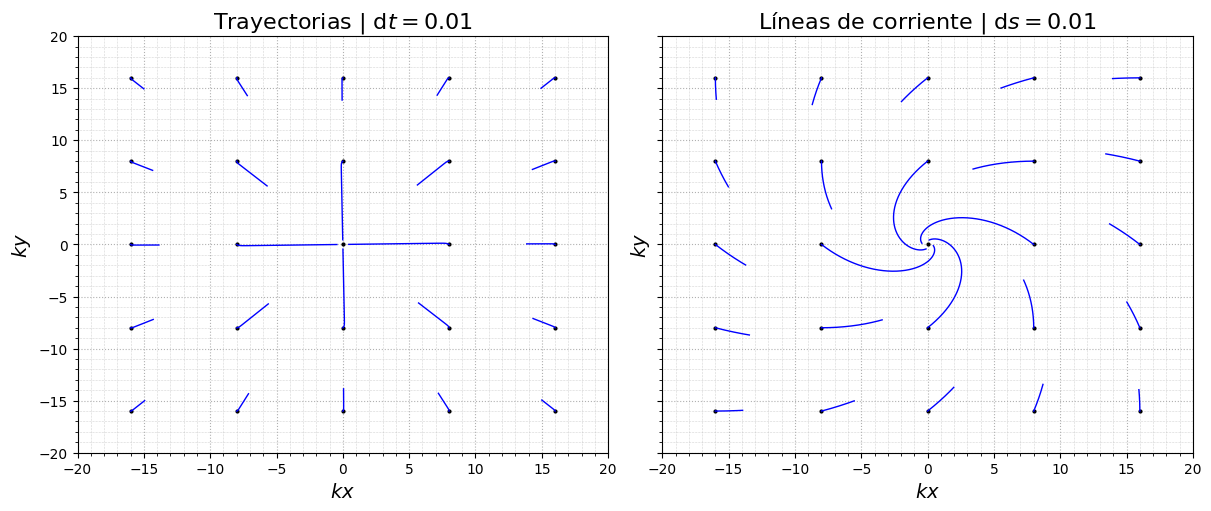

In [ ]:
def esquema(X, u, t, dt):
  """
  Calcula X(t+dt) a partir de X(t) y el campo de velocidades.

  Parámetros:
    X : Solución a tiempo t (X(t)) cómo arreglo de dimensión d
    u : Campo de velocidades cómo función de (x,t)
    t : Tiempo donde se conoce t
    dt: Paso temporal
  """
  return X+(dt/2)*(u(X,t,k)+u(X+dt*u(X,t,k),t+dt,k))

#t es el t' ya pesado por el tau

def u(X,t,k):
  R = [[],[]]
  R[0] = np.sqrt(np.abs(X[0]**2+X[1]**2))
  R[1] = np.arctan2(X[1], X[0])
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])
  return sumidero +torbellino

N = 3190
dt = 10**(-2)
#k=Q/gama
k=1



# Parámetros
lado_matriz = 4  # Número de puntos en cada fila o columna
distancia_entre_puntos = 8.0

# Generar índices de filas y columnas
indices = np.arange(-lado_matriz // 2, lado_matriz // 2 + 1)
columnas, filas = np.meshgrid(indices, indices)

# Coordenadas cartesianas
x = distancia_entre_puntos * columnas
y = distancia_entre_puntos * filas

# Crear la matriz de puntos
p0s = np.column_stack((x.flatten(), y.flatten()))



fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True,
                               sharex=True, sharey=True)

for i in range(len(p0s)):
  _, Xs = trayectoria(p0s[i], u, N, dt)
  ax1.plot(Xs[0,0], Xs[0,1], "ko", markersize=2,linewidth=1)
  ax1.plot(Xs[:,0], Xs[:,1], "b-", markersize=2,linewidth=1)


N = 3190
ds = 10**(-2)
for i in range(len(p0s)):
  _, ls = linea_de_corriente(p0s[i], u, 0, N, ds)
  ax2.plot(ls[0,0], ls[0,1], "ko", markersize=2,linewidth=1)
  ax2.plot(ls[:,0], ls[:,1], "b-", markersize=2,linewidth=1)

ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

ax1.grid(True, linestyle=':', linewidth=0.8)
ax1.minorticks_on()
ax1.grid(which='minor', linestyle=':', linewidth=0.4)
ax2.grid(True, linestyle=':', linewidth=0.8)
ax2.minorticks_on()
ax2.grid(which='minor', linestyle=':', linewidth=0.4)

ax1.set_xlabel('$kx$', fontsize=14)
ax1.set_ylabel('$ky$', fontsize=14)
ax1.set_title(f'Trayectorias | d$t={dt}$', fontsize=16)
ax2.set_xlabel('$kx$', fontsize=14)
ax2.set_ylabel('$ky$', fontsize=14)
ax2.set_title(f'Líneas de corriente | d$s={ds}$', fontsize=16)


In [ ]:
#Linea de evolucion temporal
ts = np.linspace(0, 5, 10)
evolucionar_lineas(p0s, ts, u, N, ds, ext=[-20,20,-20,20], figsize=None)

<ipython-input-7-4f996e14473d>:19: RuntimeWarning: divide by zero encountered in double_scalars
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:19: RuntimeWarning: invalid value encountered in multiply
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: invalid value encountered in multiply
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])


Calculando fotograma 9 de 10

In [ ]:
#Linea de traza
evolucionar_trazas(p0s, u, N, dt, paso=200,ext=[-20,20,-20,20], figsize=None)


<ipython-input-7-4f996e14473d>:19: RuntimeWarning: divide by zero encountered in double_scalars
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:19: RuntimeWarning: invalid value encountered in multiply
  torbellino=(1/R[0])*k*np.array([-np.sin(R[1])   , np.cos(R[1])])*np.exp(-t)
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])
<ipython-input-7-4f996e14473d>:20: RuntimeWarning: invalid value encountered in multiply
  sumidero=-(1/R[0])*k*np.array([np.cos(R[1])   , np.sin(R[1])])


Calculando fotograma 15 de 15

##Second problem: An isotermic fluid with different $\beta$ constant. The velocity field was given.

## Inciso vi

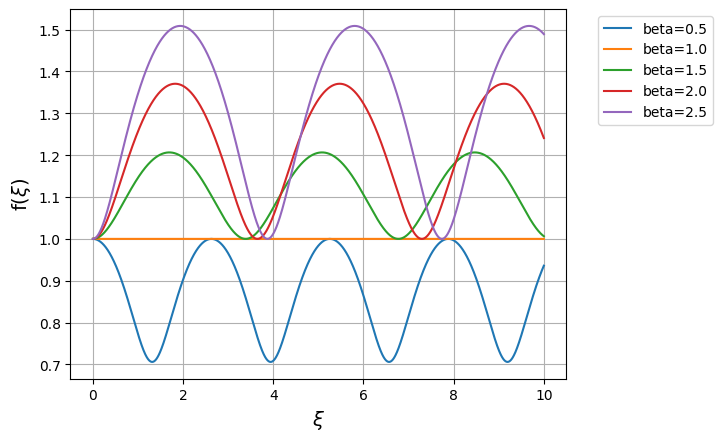

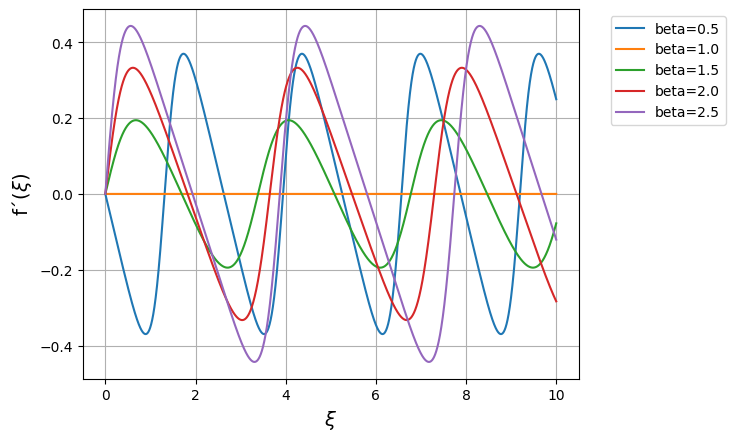

In [ ]:

def esquema(X, u, t, dt): ##rungekuta2

  return X+(dt/2)*(u(X,t)+u(X+dt*u(X,t),t+dt))

def trayectoria(X0, u, N, dt): ## esta funcion la redefino por las dudas pero es la misma que estaba antes

  d = X0.shape[0]            # Dimensión del problema
  ts = np.arange(0, N+1)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((N+1, d))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(N):
    # Aplico esquema anterior sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = esquema(Xs[j], u, ts[j], dt)
  return ts, Xs

def func(x,t): # en este caso hay dos dimensiones ya que x[0]=f y x[1]=f'
   return np.array([x[1],-1.5*(x[1]**2/x[0])+beta*(x[0]**(-3*n-1))-(1/x[0])])

n=1.4#n=1 isotermico , n=1.4 adiabatico
R0=1
X0=np.array([R0,0])
N=10000
dt=0.001
beta_lista=np.arange(0.5,3,0.5)


plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(t,x[:,0],label=f'beta={beta}')
  #plt.plot(x[:,0],x[:,1])
  plt.xlabel(r'$\xi$',fontsize=14)
  plt.ylabel(r'f($\xi$)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(t,x[:,1],label=f'beta={beta}')
  #plt.plot(t,x[:,0])
  plt.xlabel(r'$\xi$',fontsize=14)
  plt.ylabel(r'f´($\xi$)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

##Phase diagram

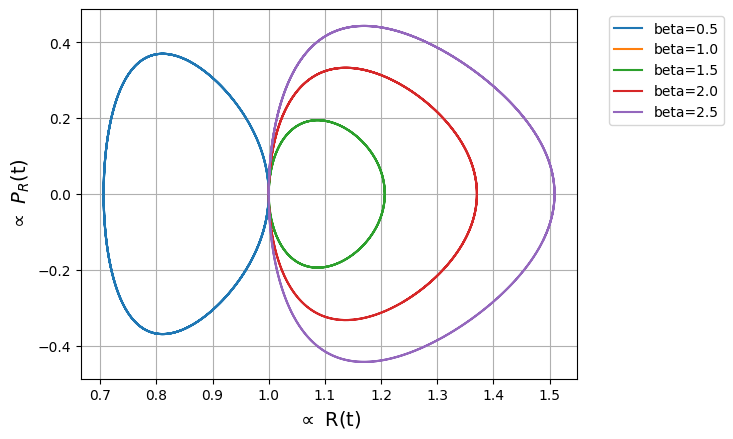

In [ ]:
#Analogia al diagrama de fases
plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(x[:,0],x[:,1],label=f'beta={beta}')
  #plt.plot(x[:,0],x[:,1])
  plt.ylabel(r'$\propto$ $P_R$(t)',fontsize=14)
  plt.xlabel(r'$\propto$ R(t)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

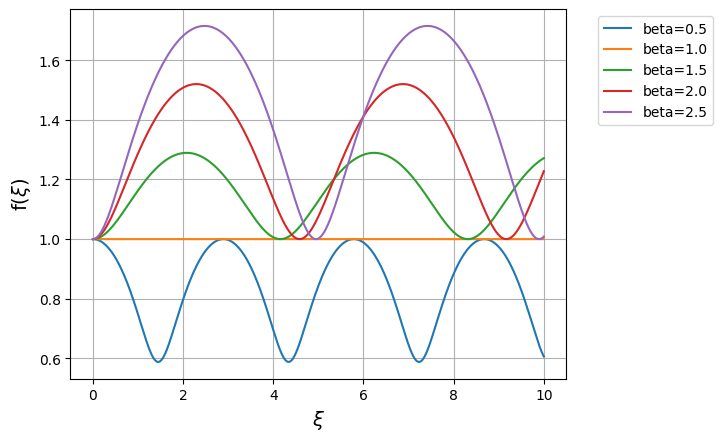

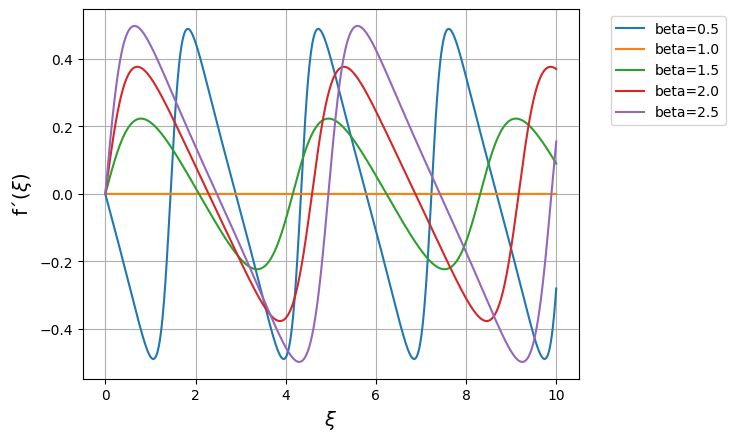

In [ ]:
n=1#n=1 isotermico , n=1.4 adiabatico
R0=1
X0=np.array([R0,0])
N=10000
dt=0.001
beta_lista=np.arange(0.5,3,0.5)


plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(t,x[:,0],label=f'beta={beta}')
  #plt.plot(x[:,0],x[:,1])
  plt.xlabel(r'$\xi$',fontsize=14)
  plt.ylabel(r'f($\xi$)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(t,x[:,1],label=f'beta={beta}')
  #plt.plot(x[:,0],x[:,1])
  plt.xlabel(r'$\xi$',fontsize=14)
  plt.ylabel(r'f´($\xi$)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

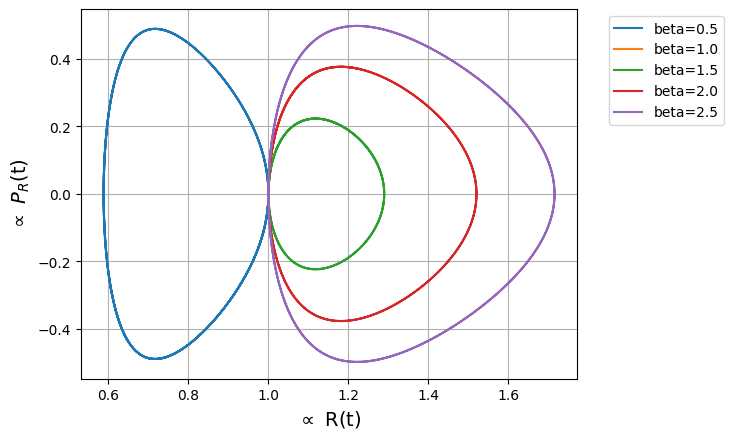

In [ ]:
#Analogia al diagrama de fases
plt.figure()
for i in range(len(beta_lista)):
  beta=beta_lista[i]
  t,x=trayectoria(X0,func,N,dt)
  plt.plot(x[:,0],x[:,1],label=f'beta={beta}')
  #plt.plot(x[:,0],x[:,1])
  plt.ylabel(r'$\propto$ $P_R$(t)',fontsize=14)
  plt.xlabel(r'$\propto$ R(t)',fontsize=14)
  plt.grid()
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

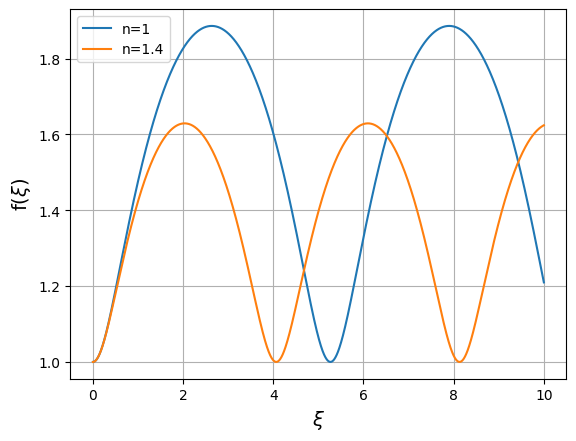

In [ ]:
#Comparativa de iso y adia
plt.figure()
R0=1
X0=np.array([R0,0])
N=10000
dt=0.001
beta=3

n=1#n=1 isotermico , n=1.4 adiabatico
t,x=trayectoria(X0,func,N,dt)
plt.plot(t,x[:,0],label=f'n=1')

n=1.4#n=1 isotermico , n=1.4 adiabatico
t,x=trayectoria(X0,func,N,dt)
plt.plot(t,x[:,0],label=f'n=1.4')

#plt.plot(x[:,0],x[:,1])
plt.xlabel(r'$\xi$',fontsize=14)
plt.ylabel(r'f($\xi$)',fontsize=14)
plt.grid()
plt.legend( loc='upper left')
plt.show()

##The problem of Lane-Emden [wikipedia](https://en.wikipedia.org/wiki/Lane%E2%80%93Emden_equation) .
Model of the gravitational potencial of a spherical object conformed by a politropic fluid.

<ipython-input-4-3bf8dcbf3881>:17: RuntimeWarning: overflow encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])
<ipython-input-4-3bf8dcbf3881>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])


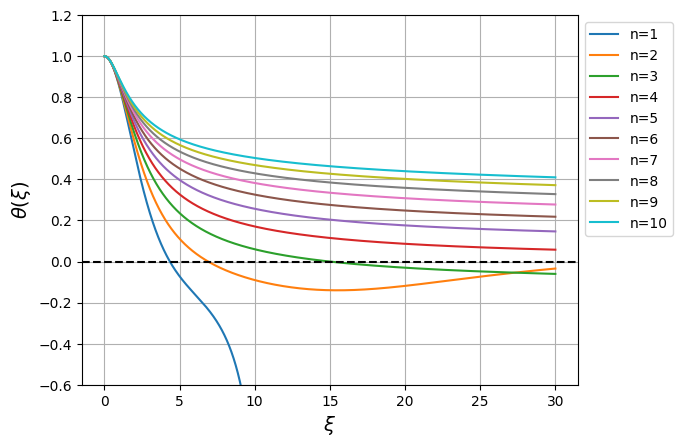

In [ ]:
# graficos en funcion de las variables xi y tita
def esquema(X, u, t, dt): ##rungekuta2

  return X+(dt/2)*(u(X,t)+u(X+dt*u(X,t),t+dt))

def trayectoria(X0, u, N, dt): ## esta funcion la redefino por las dudas pero es la misma que estaba antes

  d = X0.shape[0]            # Dimensión del problema
  ts = np.arange(1, N+2)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((N+1, d))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(N):
    # Aplico esquema anterior sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = esquema(Xs[j], u, ts[j], dt)
  return ts, Xs
def func(x,t): # en este caso hay dos dimensiones ya que x[0]=f y x[1]=f'
   return np.array([x[1],-2*x[1]/t-x[0]**n])

ns=np.array([1,2,3,4,5,6,7,8,9,10,11])
X0=np.array([1,0]) #condiciones iniciales para tita y tita'
N=30000
dt=0.001
for j in range(1,len(ns)):
  n=ns[j]
  t,x=trayectoria(X0,func,N,dt)
  if j==0:
    plt.plot(t,x[:,0],color='lawngreen',label='n='+str(j))
  else:
    plt.plot(t,x[:,0],label='n='+str(j))
plt.axhline(0,linestyle='--',color='black')
plt.grid()

plt.xlabel(r'$\xi$',fontsize=14)
plt.ylim(-0.6,1.2)

plt.ylabel(r'$\theta$($\xi$)',fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.show()

<ipython-input-8-2387d6a1b781>:17: RuntimeWarning: overflow encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])
<ipython-input-8-2387d6a1b781>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])
<ipython-input-8-2387d6a1b781>:30: RuntimeWarning: overflow encountered in square
  plt.plot(t,x[:,0]**n,label='n='+str(n))


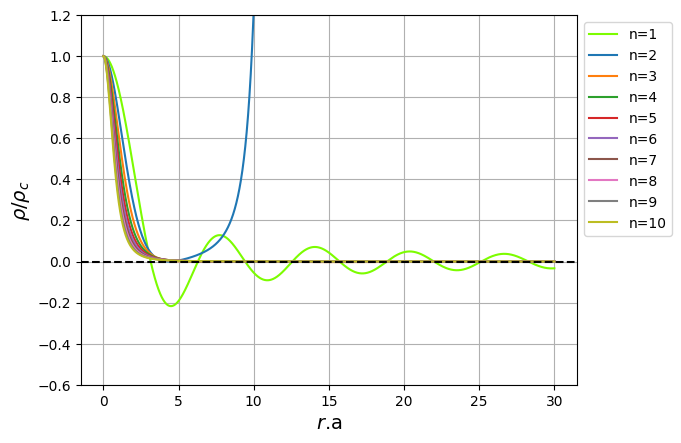

In [ ]:
#Graficos en funcion de rho y r
def esquema(X, u, t, dt): ##rungekuta2

  return X+(dt/2)*(u(X,t)+u(X+dt*u(X,t),t+dt))

def trayectoria(X0, u, N, dt): ## esta funcion la redefino por las dudas pero es la misma que estaba antes

  d = X0.shape[0]            # Dimensión del problema
  ts = np.arange(1, N+2)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((N+1, d))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(N):
    # Aplico esquema anterior sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = esquema(Xs[j], u, ts[j], dt)
  return ts, Xs

def func(x,t): # en este caso hay dos dimensiones ya que x[0]=f y x[1]=f'
   return np.array([x[1],-2*x[1]/t-x[0]**n])


ns=np.array([1,2,3,4,5,6,7,8,9,10])
X0=np.array([1,0]) #condiciones iniciales para tita y tita'
N=30000
dt=0.001
for j in range(len(ns)):
  n=ns[j]
  t,x=trayectoria(X0,func,N,dt)
  if j==0:
    plt.plot(t,x[:,0]**n,color='lawngreen',label='n='+str(n))
  else:
    plt.plot(t,x[:,0]**n,label='n='+str(n))
plt.axhline(0,linestyle='--',color='black')
plt.grid()

plt.xlabel('$r$.a',fontsize=14)
plt.ylim(-0.6,1.2)
plt.ylabel(r'$\rho$/$\rho_c$',fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


## Inciso vi

<ipython-input-8-2387d6a1b781>:17: RuntimeWarning: overflow encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])
<ipython-input-8-2387d6a1b781>:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([x[1],-2*x[1]/t-x[0]**n])


[9.424779036743322, 7.2331394832222635, 6.054708001906136]


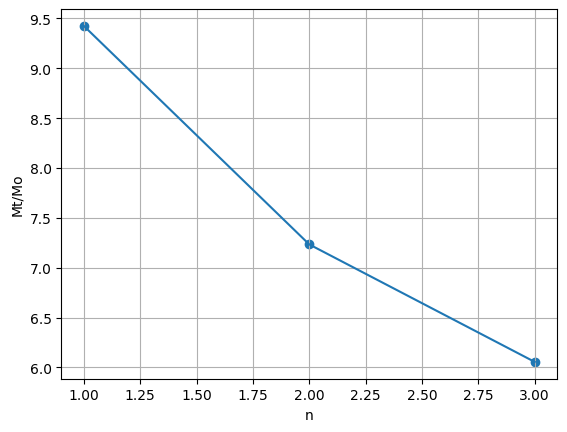

In [ ]:
#Masa adimensionalizada en funcion de n
def raices(lista,dt): #dt es el intervalo de error para encontrar el punto raiz
  dif=[]
  raices=[]
  for i in range(len(lista)):
    dif.append(np.abs(lista[i]-0))
  for j in range(len(dif)):
    if dif[j]<0+dt and dif[j]>0-dt:
      raices.append(j)
  return raices

ns=np.array([1,2,3])
lista_masas=[]
for i in range(len(ns)):
  n=ns[i]
  t,x=trayectoria(X0,func,N,dt)
  h=raices(x[:,0],dt*0.2)
  xi_min=t[h[0]]
  tita_prima=x[:,1][h[0]]
  M=-3*(xi_min**2)*x[:,1][h[0]]
  lista_masas.append(M)
print(lista_masas)
plt.scatter(ns,lista_masas)
plt.plot(ns,lista_masas)
plt.xlabel('n')
plt.ylabel('Mt/Mo')
plt.grid()

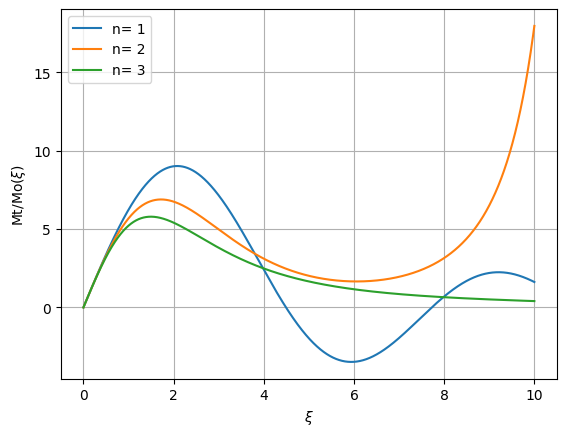

In [ ]:
#Masa adimensionalizada en funcion de xi para estrellas finitas
ns=np.array([1,2,3])
X0=np.array([1,0]) #condiciones iniciales para tita y tita'
N=10000
dt=0.001

def raices(lista,dt): #dt es el intervalo de error para encontrar el punto raiz
  dif=[]
  raices=[]
  for i in range(len(lista)):
    dif.append(np.abs(lista[i]-0))
  for j in range(len(dif)):
    if dif[j]<0+dt and dif[j]>0-dt:
      raices.append(j)
  return raices
for k in range(len(ns)):
  n=ns[k]
  t,x=trayectoria(X0,func,N,dt)
  xi_min=t[h[0]]
  tita_prima=x[:,1]
  M=-3*xi_min*x[:,1]
  plt.plot(t,M,label='n= '+str(n))


plt.xlabel(r'$\xi$')
plt.ylabel(r'Mt/Mo($\xi$)')
plt.grid()
plt.legend()